# What Are the Most Optimal Skills to Learn (Most In-Demand and Highest Paying)?

### Methodology

1. Create a table displaying the median salaries of each skill
2. Find the likelihood of seeing a specific skill in a given job posting
3. Visualise median salary Vs percentage skill demand
4. Determine if certain technologies are more prevalent than others and visualise

NOTE: all explorations will focus on the following: 
- Roles: 
  - Data Analyst
  - Data Engineer
  - Data Scientist
- Countries: 
  - United Kingdom
  - United States
  - India

### Import Libraries

In [146]:
# Importing Libraries
import ast
import pandas as pd
from datasets import load_dataset
from adjustText import adjust_text
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick
import seaborn as sns

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

## Part 1 - Create a Table Displaying the Median Salaries of Each Skill

### Apply Necessary Filters to the Dataframe

In [147]:
# List Containing Job Roles: Data Analyst, Data Engineer, Data Science
job_titles = ['Data Analyst', 'Data Engineer', 'Data Scientist']

# List Containing Countries: United Kingdom, United States, India
countries = ['United Kingdom', 'United States', 'India']

# Filter the Dataset for Job Roles and Countries
df_job_ctry = df[(df['job_title_short'].isin(job_titles)) & (df['job_country'].isin(countries))]

# Filter for US and Remove NAs in salary_year_avg
df_job_ctry = df_job_ctry.dropna(subset = ['salary_year_avg'])

# Explode  job_skills Column
df_job_ctry_exp = df_job_ctry.explode('job_skills')

# Confirm Filters are Applied Correctly
df_job_ctry_exp[['salary_year_avg', 'job_skills']].head(5)

,salary_year_avg,job_skills
92,120000.0,sql
92,120000.0,python
100,228222.0,sql
100,228222.0,r
100,228222.0,python


## Part 1 - Create a Table Displaying the Median Salaries of Each Skill

In [148]:
# Create the Table Using GroupBy()
df_skills = df_job_ctry_exp.groupby(['job_country', 'job_title_short', 'job_skills'])['salary_year_avg'].agg(['count', 'median']).sort_values(by = 'count', ascending = False)

# Rename the Aggregate Columns
df_skills = df_skills.rename(columns = {'count' : 'skill_count', 'median' : 'median_salary'})

# Reset the Index to Allow for Filtering
df_skills = df_skills.reset_index()

# View the Table
df_skills

,job_country,job_title_short,job_skills,skill_count,median_salary
0,United States,Data Scientist,python,3358,131867.0
1,United States,Data Analyst,sql,2508,91000.0
2,United States,Data Scientist,sql,2463,134500.0
3,United States,Data Engineer,sql,2110,125000.0
4,United States,Data Scientist,r,2053,126000.0
...,...,...,...,...,...
1007,United States,Data Analyst,opencv,1,67818.0
1008,United Kingdom,Data Analyst,git,1,89100.0
1009,United States,Data Analyst,node.js,1,83500.0
1010,United States,Data Scientist,clojure,1,100000.0


## Part 2 - Find the likelihood of Seeing a Specific Skill in a Given Job Posting

- SkillPercent = Probability to Find Job Skill in a Data Analyst Role
- SkillCount = Skill Count in Job Posting for a Data Analyst Role
- JobsTotal = Total Count of Job Posting for a Data Analyst

$SkillPercent = SkillCount / JobsTotal$

### Obtain Total Postings for Each Job Title and Country Combination

In [149]:
# Create Loop to Obtain List of Job Totals (Refer to Pre-Exploded Df to Get No. of Job Postings)
jobs_total = []
for i, job_title in enumerate(job_titles):
    for j, country in enumerate(countries):
        df_sum = df_job_ctry[(df_job_ctry['job_country'] == country) & (df_job_ctry['job_title_short'] == job_title)]
        df_sum = df_sum.shape[0]
        jobs_total.append({'job_title_short': job_title,
                           'job_country': country,
                           'jobs_total': df_sum})

In [150]:
# Convert Dictionary to Dataframe
df_jobs_total = pd.DataFrame(jobs_total)
df_jobs_total

,job_title_short,job_country,jobs_total
0,Data Analyst,United Kingdom,72
1,Data Analyst,United States,4350
2,Data Analyst,India,94
3,Data Engineer,United Kingdom,60
4,Data Engineer,United States,2915
5,Data Engineer,India,169
6,Data Scientist,United Kingdom,75
7,Data Scientist,United States,4553
8,Data Scientist,India,92


### Merge Jobs Total Table with Original Skills Table

In [151]:
# Recall the Previous Skills Table
df_skills

,job_country,job_title_short,job_skills,skill_count,median_salary
0,United States,Data Scientist,python,3358,131867.0
1,United States,Data Analyst,sql,2508,91000.0
2,United States,Data Scientist,sql,2463,134500.0
3,United States,Data Engineer,sql,2110,125000.0
4,United States,Data Scientist,r,2053,126000.0
...,...,...,...,...,...
1007,United States,Data Analyst,opencv,1,67818.0
1008,United Kingdom,Data Analyst,git,1,89100.0
1009,United States,Data Analyst,node.js,1,83500.0
1010,United States,Data Scientist,clojure,1,100000.0


In [152]:
# Merge Jobs Total and Skills Count Table Together
df_skills_perc = pd.merge(df_skills, df_jobs_total, how = 'left', on = ['job_title_short', 'job_country'])

### Calculate the Percentage Chance to See a Specific Skill in a Given Job Posting

In [153]:
# Create skill_percent Column in Merged Table to Obtain the Probabilities
df_skills_perc['skill_percent'] = (df_skills_perc['skill_count'] / df_skills_perc['jobs_total']) * 100
df_skills_perc

,job_country,job_title_short,job_skills,skill_count,median_salary,jobs_total,skill_percent
0,United States,Data Scientist,python,3358,131867.0,4553,73.753569
1,United States,Data Analyst,sql,2508,91000.0,4350,57.655172
2,United States,Data Scientist,sql,2463,134500.0,4553,54.096200
3,United States,Data Engineer,sql,2110,125000.0,2915,72.384220
4,United States,Data Scientist,r,2053,126000.0,4553,45.091149
...,...,...,...,...,...,...,...
1007,United States,Data Analyst,opencv,1,67818.0,4350,0.022989
1008,United Kingdom,Data Analyst,git,1,89100.0,72,1.388889
1009,United States,Data Analyst,node.js,1,83500.0,4350,0.022989
1010,United States,Data Scientist,clojure,1,100000.0,4553,0.021964


In [154]:
# Filter Table to View Job Skills with Skill Percent of over 5%
df_skills_perc = df_skills_perc[df_skills_perc['skill_percent'] > 5]
df_skills_perc

,job_country,job_title_short,job_skills,skill_count,median_salary,jobs_total,skill_percent
0,United States,Data Scientist,python,3358,131867.00,4553,73.753569
1,United States,Data Analyst,sql,2508,91000.00,4350,57.655172
2,United States,Data Scientist,sql,2463,134500.00,4553,54.096200
3,United States,Data Engineer,sql,2110,125000.00,2915,72.384220
4,United States,Data Scientist,r,2053,126000.00,4553,45.091149
...,...,...,...,...,...,...,...
597,United Kingdom,Data Analyst,sheets,4,90675.00,72,5.555556
598,United Kingdom,Data Engineer,ssrs,4,138982.25,60,6.666667
602,United Kingdom,Data Engineer,t-sql,4,114176.50,60,6.666667
603,United Kingdom,Data Analyst,flow,4,114700.00,72,5.555556


## Part 3 - Visualise Median Salary Vs Percentage Skill Demand

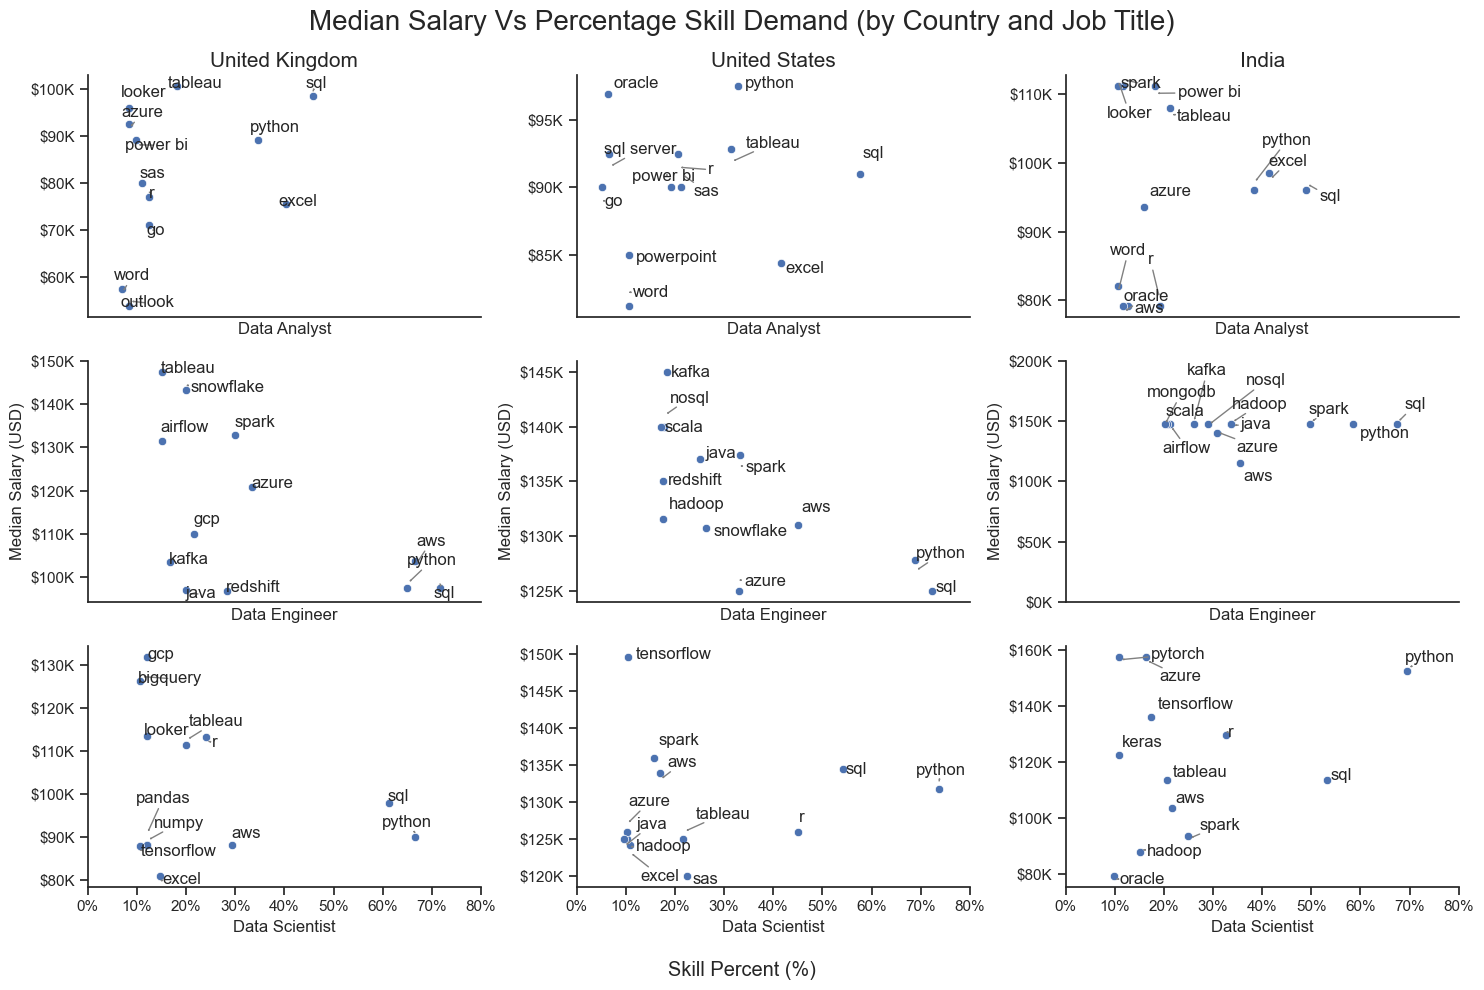

In [155]:
# Setup Figure
fig, ax = plt.subplots(len(job_titles), len(countries), figsize = (15, 10))

# Set Theme Using Seaborn
sns.set_theme(style = 'ticks')

# Will Loop Through Lists (Job Titles & Countries) a Bit Like V-Lookup
for i, job_title in enumerate(job_titles):
    for j, country in enumerate(countries):

# Filters and Orders the Skills Count Table Using the Loop to Adjust the Filters Accordingly 
        df_plot = df_skills_perc[(df_skills_perc['job_country'] == country) & (df_skills_perc['job_title_short'] == job_title)]
        df_plot = df_plot.sort_values(by = 'skill_count', ascending = False).head(12)

# Creation of the Chart Using Seaborn
        sns.scatterplot(
            data = df_plot,
            x = 'skill_percent',
            y = 'median_salary',
            ax = ax[i, j]
            )

# Create Text Labels Only for Top N Skills to Reduce Overlapping
        texts = []
        for k, txt in enumerate(df_plot['job_skills']):
            y_offset = 1000 if k % 2 == 0 else -1000
            if txt == 'pandas':
                y_offset += 1500
            text = ax[i, j].text(
                df_plot['skill_percent'].iloc[k],
                df_plot['median_salary'].iloc[k] + y_offset,  # Small Y-offset to prevent overlap
                str(txt)
            )
            texts.append(text)
            
# Adjust Texts After All Are Placed (Fixes Overlapping Issues)
        adjust_text(texts, ax=ax[i, j], force_text = (0.1, 0.5), arrowprops=dict(arrowstyle='->', color='gray'))
        
# Create Chart Titles for Top Row Only to Distinguish Column for Countri
        ax[0, j].set_title(countries[j], fontsize = 15)

# Creates y-Axis Title for Middle Charts 
        if i == 1:
            ax[i, j].set_ylabel('Median Salary (USD)')
        else:
            ax[i, j].set_ylabel('')

# Makes Y-Axis in Specific Format
        ax[i, j].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${int(x/1000)}K'))

# Sets Limits for Y-Axis to Extend To (To Scale for Each Country)
        ax[1, 2].set_ylim(0, 200000)

# Creates X-Axis Titles for All Charts
        ax[i, j].set_xlabel(job_titles[i])

# Makes the X-Axis Scale Change to Percentage Format
        ax[i, j].xaxis.set_major_formatter(PercentFormatter(xmax = 100, decimals=0))

# Removes the X-Axis Scale for Top and Middle Row Charts
        if i != len(job_titles) - 1:
            ax[i, j].set_xticks([])

# Sets Limits for X-Axis to Extend To (To Scale for Each Country)
        ax[i, 0].set_xlim(0, 80)
        ax[i, 1].set_xlim(0, 80)
        ax[i, 2].set_xlim(0, 80)
        
sns.despine()
fig.suptitle('Median Salary Vs Percentage Skill Demand (by Country and Job Title)', fontsize = 20)
fig.supxlabel('Skill Percent (%)')
plt.tight_layout()
plt.show()

## Part 4 - Determine if Certain Technologies are more Prevalent

### Create Merged Table With Corresponding Technologies Column

In [156]:
# Recall Skill Percentage Table
df_skills_perc.head(3)

,job_country,job_title_short,job_skills,skill_count,median_salary,jobs_total,skill_percent
0,United States,Data Scientist,python,3358,131867.0,4553,73.753569
1,United States,Data Analyst,sql,2508,91000.0,4350,57.655172
2,United States,Data Scientist,sql,2463,134500.0,4553,54.096200


In [157]:
# Obtain the List of Job_Skills in Order Using the df_da_skills Table
job_skill_list = df_skills_perc['job_skills'].tolist()
job_skill_list

['python',
 'sql',
 'sql',
 'sql',
 'r',
 'python',
 'excel',
 'python',
 'tableau',
 'aws',
 'sas',
 'tableau',
 'spark',
 'azure',
 'sas',
 'r',
 'power bi',
 'aws',
 'snowflake',
 'java',
 'spark',
 'kafka',
 'nosql',
 'redshift',
 'hadoop',
 'scala',
 'excel',
 'tensorflow',
 'hadoop',
 'powerpoint',
 'azure',
 'word',
 'airflow',
 'java',
 'pytorch',
 'databricks',
 'tableau',
 'power bi',
 'pandas',
 'sql server',
 'git',
 'scala',
 'oracle',
 'git',
 'mongodb',
 'sql server',
 'scikit-learn',
 'oracle',
 'power bi',
 'mysql',
 'gcp',
 'r',
 'shell',
 'numpy',
 'snowflake',
 'pyspark',
 'databricks',
 'c++',
 'docker',
 'go',
 'c',
 'go',
 'kubernetes',
 'flow',
 'ssis',
 'go',
 'postgresql',
 'cassandra',
 'bigquery',
 'linux',
 'jenkins',
 'sql',
 'python',
 'spark',
 'python',
 'aws',
 'hadoop',
 'java',
 'azure',
 'python',
 'nosql',
 'sql',
 'sql',
 'sql',
 'kafka',
 'sql',
 'aws',
 'excel',
 'python',
 'airflow',
 'python',
 'scala',
 'mongodb',
 'sql',
 'snowflake',
 'r',


In [158]:
job_ctry_list = df_skills_perc['job_country'].tolist()
job_tit_list = df_skills_perc['job_title_short'].tolist()

In [159]:
# Dictionary Shows Which job_skill Correlate to Which Technologies
dic_tech = {
    'programming': ['python', 'sql', 'r', 'sas', 'go', 'java', 'scala'],
    'analyst_tools': ['tableau', 'power bi', 'powerpoint', 'word', 'excel', 'looker', 'outlook'],
    'databases': ['sql server', 'snowflake', 'redshift', 'nosql', 'mongodb', 'bigquery', 'hadoop'],
    'cloud': ['oracle', 'azure', 'gcp', 'aws', 'airflow', 'kafka']
}

# For Loops Created to Provide Ordered List of Technology Types
technologies_list = []
for item in job_skill_list:
    category = next((key for key, values in dic_tech.items() if item in values), '')  # Efficient lookup
    technologies_list.append(category)

technologies_list

# NOTE: next() allows for efficient category lookup. Stops searching once match is found

['programming',
 'programming',
 'programming',
 'programming',
 'programming',
 'programming',
 'analyst_tools',
 'programming',
 'analyst_tools',
 'cloud',
 'programming',
 'analyst_tools',
 '',
 'cloud',
 'programming',
 'programming',
 'analyst_tools',
 'cloud',
 'databases',
 'programming',
 '',
 'cloud',
 'databases',
 'databases',
 'databases',
 'programming',
 'analyst_tools',
 '',
 'databases',
 'analyst_tools',
 'cloud',
 'analyst_tools',
 'cloud',
 'programming',
 '',
 '',
 'analyst_tools',
 'analyst_tools',
 '',
 'databases',
 '',
 'programming',
 'cloud',
 '',
 'databases',
 'databases',
 '',
 'cloud',
 'analyst_tools',
 '',
 'cloud',
 'programming',
 '',
 '',
 'databases',
 '',
 '',
 '',
 '',
 'programming',
 '',
 'programming',
 '',
 '',
 '',
 'programming',
 '',
 '',
 'databases',
 '',
 '',
 'programming',
 'programming',
 '',
 'programming',
 'cloud',
 'databases',
 'programming',
 'cloud',
 'programming',
 'databases',
 'programming',
 'programming',
 'programming',
 

In [160]:
# Create a Dataframe Combining Both Lists
df_tech = {
    'job_country' : job_ctry_list,
    'job_title_short' : job_tit_list,
    'job_skills' : job_skill_list,
    'technology' : technologies_list
    }
df_tech = pd.DataFrame(df_tech)

# Allows for Filtering
df_tech.reset_index()

df_tech

,job_country,job_title_short,job_skills,technology
0,United States,Data Scientist,python,programming
1,United States,Data Analyst,sql,programming
2,United States,Data Scientist,sql,programming
3,United States,Data Engineer,sql,programming
4,United States,Data Scientist,r,programming
...,...,...,...,...
228,United Kingdom,Data Analyst,sheets,
229,United Kingdom,Data Engineer,ssrs,
230,United Kingdom,Data Engineer,t-sql,
231,United Kingdom,Data Analyst,flow,


In [161]:
# Merge the Dataframes
df_tech_perc_merge = pd.merge(df_skills_perc, df_tech, how = 'left', on = ['job_country', 'job_title_short', 'job_skills'])
df_tech_perc_merge

,job_country,job_title_short,job_skills,skill_count,median_salary,jobs_total,skill_percent,technology
0,United States,Data Scientist,python,3358,131867.00,4553,73.753569,programming
1,United States,Data Analyst,sql,2508,91000.00,4350,57.655172,programming
2,United States,Data Scientist,sql,2463,134500.00,4553,54.096200,programming
3,United States,Data Engineer,sql,2110,125000.00,2915,72.384220,programming
4,United States,Data Scientist,r,2053,126000.00,4553,45.091149,programming
...,...,...,...,...,...,...,...,...
228,United Kingdom,Data Analyst,sheets,4,90675.00,72,5.555556,
229,United Kingdom,Data Engineer,ssrs,4,138982.25,60,6.666667,
230,United Kingdom,Data Engineer,t-sql,4,114176.50,60,6.666667,
231,United Kingdom,Data Analyst,flow,4,114700.00,72,5.555556,


### Visualise if Certain Technologies are More Prevalent Than Others

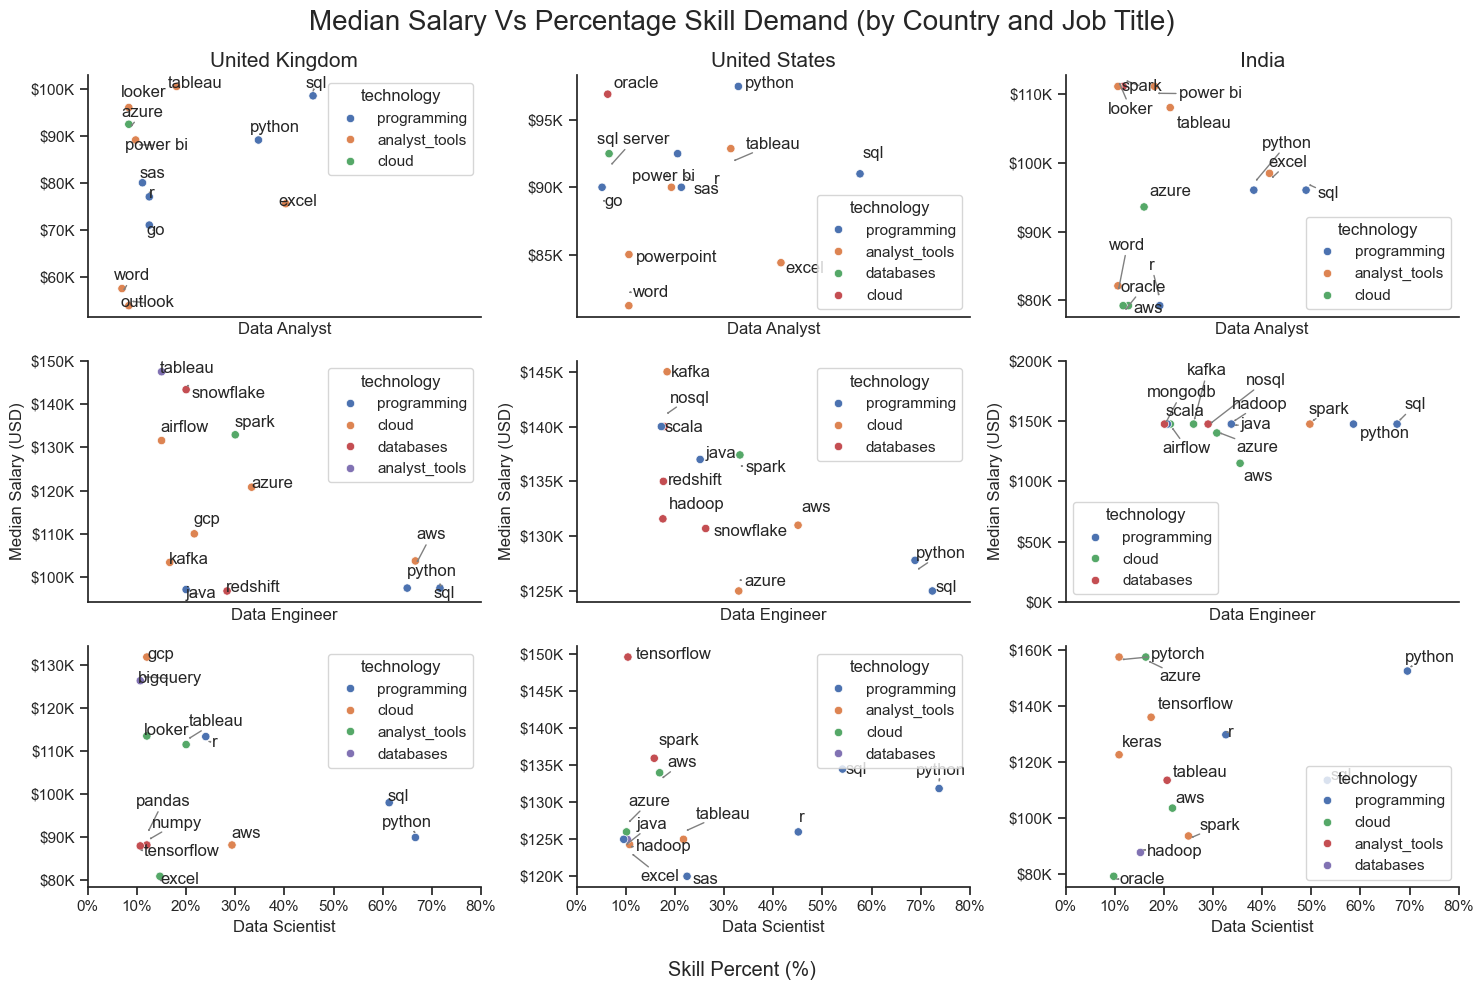

In [162]:
# Setup Figure
fig, ax = plt.subplots(len(job_titles), len(countries), figsize = (15, 10))

# Set Theme Using Seaborn
sns.set_theme(style = 'ticks')

# Will Loop Through Lists (Job Titles & Countries) a Bit Like V-Lookup
for i, job_title in enumerate(job_titles):
    for j, country in enumerate(countries):

# Filters and Orders the Skills Count Table Using the Loop to Adjust the Filters Accordingly 
        df_plot = df_tech_perc_merge[(df_tech_perc_merge['job_country'] == country) & (df_tech_perc_merge['job_title_short'] == job_title)]
        df_plot = df_plot.sort_values(by = 'skill_count', ascending = False).head(12)

# Creation of the Chart Using Seaborn
        sns.scatterplot(
            data = df_plot,
            x = 'skill_percent',
            y = 'median_salary',
            hue = 'technology',
            ax = ax[i, j]
            )

# Create Text Labels Only for Top N Skills to Reduce Overlapping
        texts = []
        for k, txt in enumerate(df_plot['job_skills']):
            y_offset = 1000 if k % 2 == 0 else -1000
            if txt == 'pandas':
                y_offset += 1500
            text = ax[i, j].text(
                df_plot['skill_percent'].iloc[k],
                df_plot['median_salary'].iloc[k] + y_offset,  # Small Y-offset to prevent overlap
                str(txt)
            )
            texts.append(text)
            
# Adjust Texts After All Are Placed (Fixes Overlapping Issues)
        adjust_text(texts, ax=ax[i, j], force_text = (0.1, 0.5), arrowprops=dict(arrowstyle='->', color='gray'))
        
# Create Chart Titles for Top Row Only to Distinguish Column for Countri
        ax[0, j].set_title(countries[j], fontsize = 15)

# Creates y-Axis Title for Middle Charts 
        if i == 1:
            ax[i, j].set_ylabel('Median Salary (USD)')
        else:
            ax[i, j].set_ylabel('')

# Makes Y-Axis in Specific Format
        ax[i, j].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${int(x/1000)}K'))

# Sets Limits for Y-Axis to Extend To (To Scale for Each Country)
        ax[1, 2].set_ylim(0, 200000)

# Creates X-Axis Titles for All Charts
        ax[i, j].set_xlabel(job_titles[i])

# Makes the X-Axis Scale Change to Percentage Format
        ax[i, j].xaxis.set_major_formatter(PercentFormatter(xmax = 100, decimals=0))

# Removes the X-Axis Scale for Top and Middle Row Charts
        if i != len(job_titles) - 1:
            ax[i, j].set_xticks([])

# Sets Limits for X-Axis to Extend To (To Scale for Each Country)
        ax[i, 0].set_xlim(0, 80)
        ax[i, 1].set_xlim(0, 80)
        ax[i, 2].set_xlim(0, 80)
        
sns.despine()
fig.suptitle('Median Salary Vs Percentage Skill Demand (by Country and Job Title)', fontsize = 20)
fig.supxlabel('Skill Percent (%)')
plt.tight_layout()
plt.show()